In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import backtrader as bt
import numpy as np
from datetime import datetime 
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [11]:
str(datetime.now())

'2021-02-17 00:59:36.083047'

In [3]:
end = datetime.now() 
start = datetime(end.year - 5, end.month , end.day)
bad = []

tickers = pd.read_csv('~/Documents/GitHub/triplec-quant-trading/data/survivorship-free/tickers.csv', header=None)[1].tolist()
stocks = (
    (pd.concat(
        [pd.read_csv(f"~/Documents/GitHub/triplec-quant-trading/data/survivorship-free/{ticker}.csv", index_col='date', parse_dates=True)[
            'close'
        ].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)
stocks = stocks.loc[:,~stocks.columns.duplicated()]

In [4]:
class CrossSectionalMR(bt.Strategy):
    def prenext(self):
        self.next()
    
    def next(self):
        # only look at data that existed yesterday
        available = list(filter(lambda d: len(d), self.datas)) 
        
        rets = np.zeros(len(available))
        for i, d in enumerate(available):
            # calculate individual daily returns
            rets[i] = (d.close[0]- d.close[-1]) / d.close[-1]

        # calculate weights using formula
        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        weights = weights / np.sum(np.abs(weights))
        
        for i, d in enumerate(available):
            self.order_target_percent(d, target=weights[i])

In [5]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

for ticker in tickers:
    data = bt.feeds.GenericCSVData(
        fromdate=start,
        todate=end,
        dataname=f"../data/survivorship-free/{ticker}.csv",
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        nullvalue=0.0,
        plot=False,
        adjclose = False
    )
    cerebro.adddata(data)

cerebro.broker.setcash(1_000_000)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.01)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(CrossSectionalMR)
results = cerebro.run()

In [6]:
import os
os.path.isdir('../data/survivorship-free')

True

Sharpe: 0.713
Norm. Annual Return: 4.38%
Max Drawdown: 7.61%


<IPython.core.display.Javascript object>


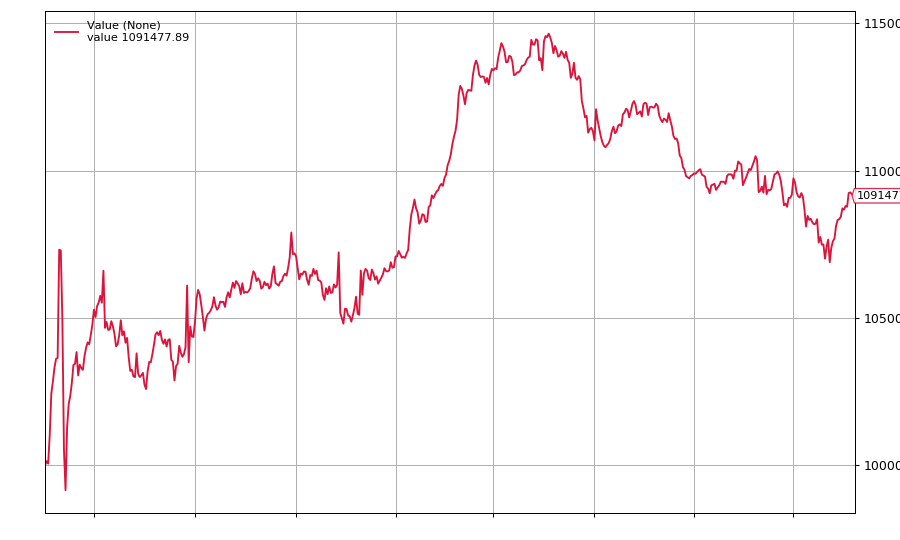

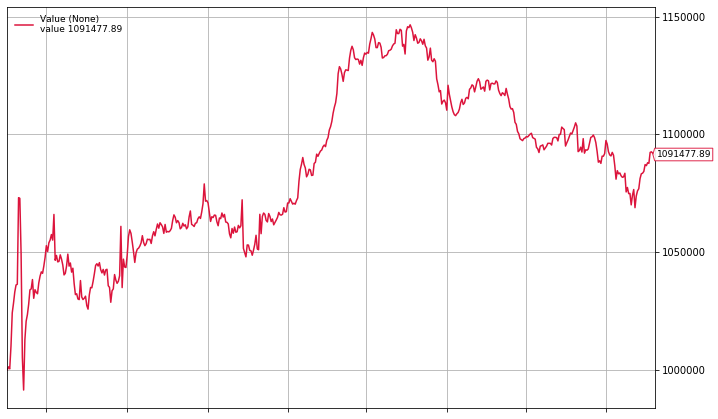

In [7]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot()[0][0]

In [9]:
cerebro.plot()

[[<Figure size 720x432 with 1 Axes>]]